In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import torch.nn as nn
from tqdm import tqdm_notebook as tqdm

TRAIN = False

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, ), (0.5, ))])

trainset = torchvision.datasets.MNIST(root='./data', 
                                        train=True,
                                        download=True,
                                        transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,
                                            batch_size=100,
                                            shuffle=True,
                                            num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', 
                                        train=False, 
                                        download=True, 
                                        transform=transform)
testloader = torch.utils.data.DataLoader(testset, 
                                            batch_size=100,
                                            shuffle=False, 
                                            num_workers=2)

classes = tuple(np.linspace(0, 9, 10, dtype=np.uint8))

In [2]:
raw_y = np.array([int(y) for y in trainset.targets])
raw_x = np.array([y for y in trainset.data.numpy()])

In [3]:
idx = trainset.train_labels==1
trainset.targets = trainset.targets[idx]
trainset.data = trainset.data[idx]

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [4]:
idx = testset.train_labels==6
testset.targets = testset.targets[idx]
testset.data = testset.data[idx]

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


set dataloader

In [5]:
trainloader = torch.utils.data.DataLoader(trainset,
                                            batch_size=100,
                                            shuffle=True,
                                            num_workers=2)
testloader = torch.utils.data.DataLoader(testset, 
                                            batch_size=100,
                                            shuffle=False, 
                                            num_workers=2)

In [6]:
testset = torchvision.datasets.MNIST(root='./data', 
                                        train=False, 
                                        download=True, 
                                        transform=transform)
idx = testset.train_labels==1
testset.targets = testset.targets[idx]
testset.data = testset.data[idx]
testloader1 = torch.utils.data.DataLoader(testset, 
                                            batch_size=100,
                                            shuffle=False, 
                                            num_workers=2)


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


## define model

In [7]:
import pretrainedmodels
model_name = "resnet18"
basemodel = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained='imagenet')
basemodel = nn.Sequential(*list(basemodel.children())[1:-2])

In [8]:
from metrics import ArcMarginProduct
class mymodel(nn.Module):
    def __init__(self):
        super(mymodel, self).__init__()
        self.features = basemodel
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1, bias=False)
        if model_name == "resnet34" or model_name == "resnet18":
            num_ch = 512
        else:
            num_ch = 2048
        # vowel_diacritic       
        self.fc1 = nn.Conv2d(num_ch, 1, 1)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        
    def forward(self, x):
        # extract features
        x = self.conv1(x)
        x = self.features(x)
        x = self.avgpool(x).squeeze(2).squeeze(2)

        #x1 = self.arcface(x).squeeze(2).squeeze(2)
        
        return x

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device="cpu"
#model2 = mymodel()
#input = torch.rand(10,1,28,28)
#model2(input).size()

In [10]:
model = mymodel()
model = model.to(device)

# define arcface

In [11]:
metric_fc = ArcMarginProduct(512, 2, s=30, m=0.5, easy_margin=False).to(device)

In [12]:
optimizer = torch.optim.Adam([{'params': model.parameters()}, {'params': metric_fc.parameters()}],
                                     lr=1e-4)

In [13]:
criterion = torch.nn.CrossEntropyLoss()

## train script

In [14]:
def train(epoch):
    model.train()
    print('epochs {}/{} '.format(epoch+1,epochs))
    running_loss = 0.0
    running_acc = 0.0
    acc1 = 0.0
    acc2 = 0.0
    acc3 = 0.0
    t = tqdm(trainloader)
    
    for idx, (inputs,labels1) in enumerate(t):       
        # send to gpu
        inputs = inputs.to(device)
        labels1 = torch.zeros(inputs.size()[0]).to(device).long() #.unsqueeze(1)
        
        # set opt
        optimizer.zero_grad()
        
        # run model
        feat = model(inputs.float())
        outputs = metric_fc(feat, labels1)
        #print(feat.size())
        #print(labels1.size())
        #print(outputs.size())
        loss = criterion(outputs,labels1)
        #running_loss += loss
        
        loss.backward()
        optimizer.step()
        
        if idx%8==7:
            print(loss.item())
        

In [15]:
def eval(epoch):
    model.eval()
    print('epochs {}/{} '.format(epoch+1,epochs))
    running_loss = 0.0
    running_acc = 0.0
    acc1 = 0.0
    acc2 = 0.0
    acc3 = 0.0
    t = tqdm(testloader)
    
    for idx, (inputs,labels1) in enumerate(t):       
        # send to gpu
        inputs = inputs.to(device)
        labels1 = torch.zeros(inputs.size()[0]).to(device).long()+1 #.unsqueeze(1)
        
        # set opt
        optimizer.zero_grad()
        
        # run model
        feat = model(inputs.float())
        outputs = metric_fc(feat, labels1)
        print(outputs)
        #print(feat.size())
        #print(labels1.size())
        #print(outputs.size())
        loss = criterion(outputs,labels1)
        #running_loss += loss
        
        #loss.backward()
        #optimizer.step()
        
        if idx%8==7:
            print(loss.item())
        

In [16]:
def eval2(epoch):
    model.eval()
    print('epochs {}/{} '.format(epoch+1,epochs))
    running_loss = 0.0
    running_acc = 0.0
    acc1 = 0.0
    acc2 = 0.0
    acc3 = 0.0
    t = tqdm(trainloader)
    
    for idx, (inputs,labels1) in enumerate(t):       
        # send to gpu
        inputs = inputs.to(device)
        labels1 = torch.zeros(inputs.size()[0]).to(device).long() #.unsqueeze(1)
        
        # set opt
        optimizer.zero_grad()
        
        # run model
        feat = model(inputs.float())
        outputs = metric_fc(feat, labels1)
        print(outputs)
        #print(feat.size())
        #print(labels1.size())
        #print(outputs.size())
        loss = criterion(outputs,labels1)
        #running_loss += loss
        
        #loss.backward()
        #optimizer.step()
        
        if idx%8==7:
            print(loss.item())
        

In [17]:
epochs = 8
if TRAIN:
    for epoch in range(epochs):
        train(epoch)
        torch.save(model.state_dict(), './saved_weights.pth')
else:
    model.load_state_dict(torch.load('./saved_weights.pth'))

epochs 1/8 


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


4.4535698890686035
1.1313917636871338
0.5515666007995605
0.6664652228355408
0.4946076571941376
0.5413792133331299
0.8707285523414612
0.7057856917381287

epochs 2/8 


0.5974326133728027
0.3724251687526703
0.7212369441986084
0.43410027027130127
0.26967671513557434
0.5941429734230042
0.3742329776287079
0.26902657747268677

epochs 3/8 


0.3716716766357422
0.3840203583240509
0.5140705704689026
0.21742035448551178
0.3703902065753937
0.27871906757354736
0.3834840655326843
0.18724575638771057

epochs 4/8 


0.4096241891384125
0.19155943393707275
0.48104870319366455
0.1530882567167282
0.1455255001783371
0.1597006916999817
0.14178186655044556
0.14873544871807098

epochs 5/8 


0.16447903215885162
0.15023010969161987
0.24240140616893768
0.13530105352401733
0.121891088783741
0.1226428672671318
0.2542761266231537
0.1142316460609436

epochs 6/8 


0.10973546653985977
0.10740123689174652
0.11055757850408554
0.10244772583246231
0.10041572898626328
0.1049920842051506
0.09308633208274841
0.09679301083087921

epochs 7/8 


0.08669183403253555
0.08223548531532288
0.09283848851919174
0.0762028694152832
0.0714244395494461
0.06705695390701294
0.06313810497522354
0.05803818628191948

epochs 8/8 


0.05538932979106903
0.08281014114618301
0.06851176917552948
0.05308976769447327
0.02916851080954075
0.049861274659633636
0.016543112695217133
0.05764516443014145



In [18]:
def cosin_metric(x1, x2):
    return np.dot(x1, x2)# / (np.linalg.norm(x1) * np.linalg.norm(x2))

In [19]:
model.eval()
with torch.no_grad():
    train = trainset[0][0]
    out1 = model(train.unsqueeze(0).to(device)).cpu().numpy()
    test = testset[0][0]
    out2 = model(test.unsqueeze(0).to(device)).cpu().numpy()

print("different number:", cosin_metric(out1, out2.T))


different number: [[44.889015]]


In [20]:
with torch.no_grad():
    train = trainset[0][0]
    out1 = model(train.unsqueeze(0).to(device)).cpu().numpy()
    test = trainset[2][0]
    out2 = model(test.unsqueeze(0).to(device)).cpu().numpy()
    
print("same number:", cosin_metric(out1, out2.T))

same number: [[44.476593]]


In [21]:
torch.cuda.empty_cache()

## inference and evaluate distance.

In [26]:
t = tqdm(trainloader)  
for idx, (inputs,labels1) in enumerate(t):       
    # send to gpu
    inputs = inputs.to(device)
    labels1 = torch.zeros(inputs.size()[0]).to(device).long() #.unsqueeze(1)
    # run model
    with torch.no_grad():
        out = model(inputs.float())
    if idx  == 0:
        outs = out
    else:
        outs = torch.cat((outs, out))

normals = outs.cpu().numpy()

t = tqdm(testloader1)  
for idx, (inputs,labels1) in enumerate(t):       
    # send to gpu
    inputs = inputs.to(device)
    labels1 = torch.zeros(inputs.size()[0]).to(device).long() #.unsqueeze(1)
    # run model
    with torch.no_grad():
        out = model(inputs.float())
    if idx  == 0:
        outs = out
    else:
        outs = torch.cat((outs, out))

normals1 = outs.cpu().numpy()

t = tqdm(testloader)  
for idx, (inputs,labels1) in enumerate(t):       
    # send to gpu
    inputs = inputs.to(device)
    labels1 = torch.zeros(inputs.size()[0]).to(device).long() #.unsqueeze(1)
    # run model
    with torch.no_grad():
        out = model(inputs.float())
    if idx  == 0:
        outs = out
    else:
        outs = torch.cat((outs, out))
        
abnormals = outs.cpu().numpy()

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel_launcher.py:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [23]:
print(normals.shape)
print(abnormals.shape)

(6742, 512)
(958, 512)


In [50]:
same = np.clip(np.mean(cosin_metric(normals, normals1.T), axis=0), 0, 100)
same.shape

(1135,)

In [51]:
different = np.clip(np.mean(cosin_metric(normals, abnormals.T), axis=0), 0, 100)
different.shape

(958,)

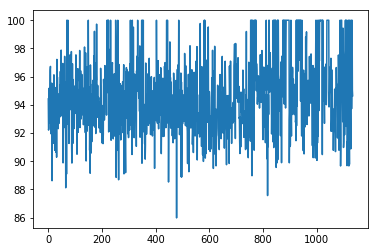

In [52]:
# print scatter plot of same 1s
import matplotlib.pyplot as plt
plt.plot(same)

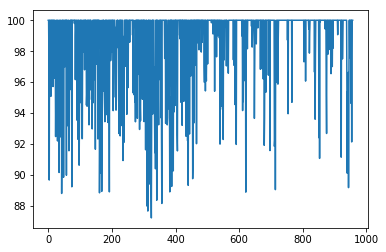

In [53]:
plt.plot(different)

In [55]:
np.sum(different>=100)

626

In [56]:
np.sum(same>=100)

108